# Clasificación GBC
En este notebook vamos a realizar la clasificación de los datos con el clasificador Gradient Boosting. Obtendremos algunas métricas y plots para analizar su rendimiento y compararemos la distribución de los datos reales y la obtenida con la clasificación.

## Cargamos los datos

In [1]:
# Importamos las librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, log_loss, recall_score, plot_confusion_matrix,classification_report, f1_score
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Importamos los datos
datos = ['../data/RD_GBC_0', '../data/RD_GBC_1', '../data/RD_GBC_2', '../data/RD_GBC_3', '../data/RD_GBC_4',
        '../data/RD_GBC_5', '../data/RD_GBC_6', '../data/RD_GBC_7', '../data/RD_GBC_8', '../data/RD_GBC_9']
df = pd.DataFrame()

for path in datos:
    df_i = pd.read_csv(path)
    df = pd.concat([df, df_i])
    
df.shape

(512000, 18)

In [3]:
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrones_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrones_j2,m_jj,deltaR_j12,n_hadrones,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,170.076344,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,1053.333258,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,759.634459,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,691.631325,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,284.861613,3.629229,169.0,1.0


**Separamos la data** en un conjunto de datos de entrenamiento y un conjunto de datos de prueba:

In [4]:
# Definimos una función para separar un dataframe en caracteristicas y label

from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None  # default='warn'

def data_ready(df, label='label'):
    
    # Creamos una lista con las características a considerar en el modelo
    carac_cols = df.columns.values.tolist()
    
    # Eliminamos 'label' porque no es una característica
    carac_cols.remove(label)

    # Hacemos un dataframe solo con las características
    X = df[carac_cols]
    
    # Normalizamos los datos
    for column in list(X.columns):
        feature = np.array(X[column]).reshape(-1,1)
        scaler = MinMaxScaler()
        scaler.fit(feature)
        feature_scaled = scaler.transform(feature)
        X[column] = feature_scaled.reshape(1,-1)[0]

    # Obtenemos la serie con la información sobre señal o fondo
    y = df[label]
    
    return X, y

In [6]:
X, y = data_ready(df)
X_train_m, X_test_m, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Eliminamos las columnas de masa para que el entrenamiento sea libre de modelo
X_train = X_train_m.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
X_test = X_test_m.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)

Vemos que la distribución de clases coincida en ambos conjuntos de datos

In [7]:
print('y_train class distribution')
print(y_train.value_counts(normalize=True))

print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
0.0    0.908714
1.0    0.091286
Name: label, dtype: float64
y_test class distribution
0.0    0.908711
1.0    0.091289
Name: label, dtype: float64


## Clasificación
Definimos el clasificador, lo entrenamos y hacemos las predicciones

In [8]:
clf = GradientBoostingClassifier()
nombre = clf.__class__.__name__

clf.fit(X_train, y_train)
y_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

Obtenemos métricas de acuerdo a la clasificación:

In [9]:
print(classification_report(y_test, y_pred, target_names=['fondo','señal']))

              precision    recall  f1-score   support

       fondo       0.96      0.99      0.97    139578
       señal       0.81      0.60      0.69     14022

    accuracy                           0.95    153600
   macro avg       0.89      0.79      0.83    153600
weighted avg       0.95      0.95      0.95    153600



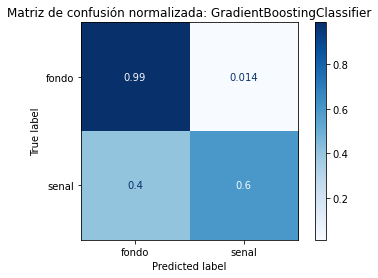

In [10]:
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['fondo','senal'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title("Matriz de confusión normalizada: {}".format(nombre))
plt.show()

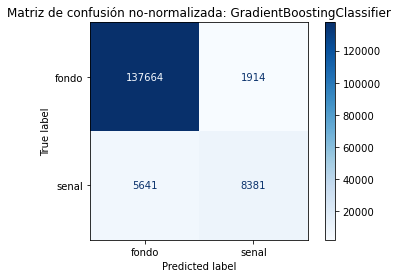

In [11]:
disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=['fondo','senal'],
                             cmap=plt.cm.Blues,
                             normalize=None)

disp.ax_.set_title("Matriz de confusión no-normalizada: {}".format(nombre))

plt.show()

In [12]:
precision = precision_score(y_test, y_pred)
ll = log_loss(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print("Precision: {} \n Log score: {:.4f} \n F1 score: {:.4f}".format(precision ,ll, f1))

Precision: 0.8140845070422535 
 Log score: 0.1338 
 F1 score: 0.6893


In [13]:
fi_gb = clf.feature_importances_.tolist()
peso = [ round(elem, 3) for elem in fi_gb ]
features = X_train.columns.tolist()
scores = list(zip(features, peso))
scores

[('pT_j1', 0.073),
 ('eta_j1', 0.0),
 ('phi_j1', 0.001),
 ('E_j1', 0.001),
 ('tau_21_j1', 0.231),
 ('nhadrones_j1', 0.013),
 ('pT_j2', 0.257),
 ('eta_j2', 0.0),
 ('phi_j2', 0.001),
 ('E_j2', 0.002),
 ('tau_21_j2', 0.232),
 ('nhadrones_j2', 0.009),
 ('deltaR_j12', 0.057),
 ('n_hadrones', 0.124)]

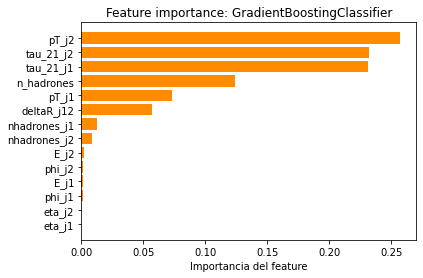

In [14]:
# Ordenamos de menor a mayor
scores.sort(key=lambda x: x[1], reverse=False) 

# Salvamos los nombres y su puntaje separados
# y revertimos las tuplas para tener de mayor a menor puntaje  
features = list(zip(*scores))[0]
score = list(zip(*scores))[1]
x_pos = np.arange(len(features)) 

# Graficamos
plt.barh(x_pos, score,align='center', color = 'darkorange')
plt.yticks(x_pos, features) 
plt.xlabel('Importancia del feature')
plt.title('Feature importance: {}'.format(nombre))
plt.show()

## ROC y AUC
Graficamos la curva ROC y obtenemos el puntaje AUC

In [15]:
def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_proba[:, 1])

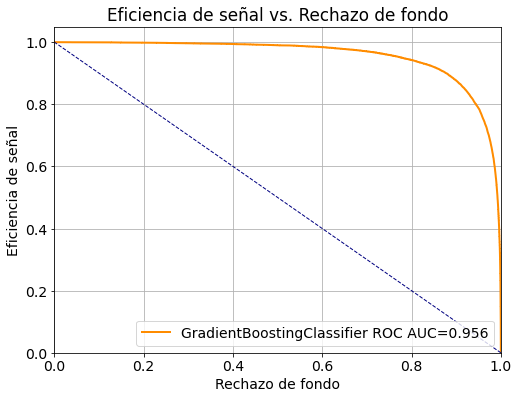

In [17]:
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

plt.plot(1-fpr, tpr, color='darkorange', lw=2,
         label='{} ROC AUC={:.3f}'.format(nombre, roc_auc))


plt.plot([1, 0], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Rechazo de fondo')
plt.ylabel('Eficiencia de señal')
plt.title('Eficiencia de señal vs. Rechazo de fondo')
plt.show()

Graficamos otro tipo de ROC

<ipython-input-18-19eb22cb2463>:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, 1/fpr, color='darkorange', lw=2,


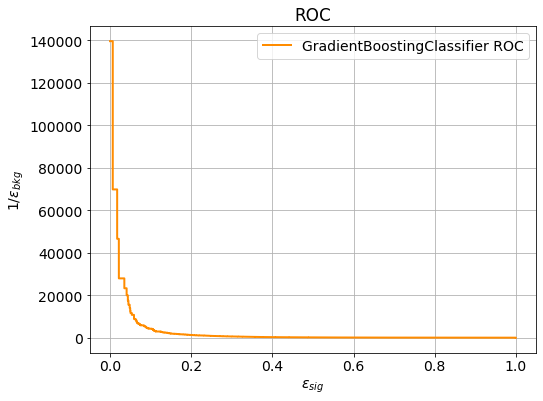

In [18]:
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

plt.plot(tpr, 1/fpr, color='darkorange', lw=2,
         label='{} ROC'.format(nombre))


plt.legend(loc="upper right")
plt.xlabel('$\epsilon_{sig}$')
plt.ylabel('$1/\epsilon_{bkg}$')
plt.title('ROC')
plt.show()

## Distribuciones
Hacemos plots de las distribuciones **después de la clasificación**

In [19]:
def plot_comp(df, variable, jets = 'principales', n_bins=50, log=False):
    pred_fondo = df[df['y_pred'] == 0]
    pred_sig = df[df['y_pred'] == 1]

    fondo = df[df['y_test'] == 0]
    sig = df[df['y_test'] == 1]
    
    fondopred = pred_fondo[variable]
    senalpred = pred_sig[variable]

    fondo = fondo[variable]
    senal = sig[variable]
    
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    titulo = 'Distribución de {}'.format(variable)
    
    # Hacemos los histogramas
    
    if type(fondo)==list:
        plt.hist(fondopred, bins=n_bins, histtype='step', log=log, color='green', label='fondo pred', density=True)
        plt.hist(senalpred, bins=n_bins, histtype='step', log=log, color='orange', label='señal pred', density=True)
        
        plt.hist(fondo, bins=n_bins, log=log, facecolor='blue', alpha=0.2, label='green', density=True)
        plt.hist(senal, bins=n_bins, log=log, facecolor='red', alpha=0.2, label='señal', density=True)
        
    else:
        fondopred.plot.hist(bins=n_bins, histtype='step', log=log, color='green', label='fondo pred', density=True)
        senalpred.plot.hist(bins=n_bins, histtype='step', log=log, color='orange', label='señal pred', density=True)
        
        fondo.plot.hist(bins=n_bins, log=log, facecolor='blue', alpha=0.2, label='fondo', density=True)
        senal.plot.hist(bins=n_bins, log=log, facecolor='red', alpha=0.2, label='señal', density=True)

    # Agregamos información al gráfico
    plt.xlabel(variable)
    plt.ylabel('Densidad de eventos')
    plt.legend(loc='upper right')
    plt.title(titulo)
    
    return plt.show()

In [20]:
X_test_m['y_pred'] = y_pred
X_test_m['y_test'] = y_test

X_test_m.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrones_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrones_j2,m_jj,deltaR_j12,n_hadrones,y_pred,y_test
7704,0.016109,0.333058,0.366290,0.908541,0.079008,0.192169,0.389764,0.209490,0.037045,0.665808,0.373096,0.196008,0.229291,0.120968,0.273289,0.584328,0.276923,0.0,0.0
13843,0.103104,0.069838,0.531927,0.559239,0.064934,0.540174,0.149606,0.298696,0.036838,0.500908,0.062098,0.182935,0.335004,0.104839,0.070945,0.450961,0.136752,0.0,0.0
44955,0.084199,0.057472,0.389006,0.567999,0.085474,0.472201,0.118110,0.194146,0.170809,0.589416,0.093343,0.141639,0.261287,0.350806,0.157634,0.449102,0.283761,0.0,0.0
6850,0.021802,0.123702,0.753051,0.715537,0.215372,0.553010,0.196850,0.235026,0.174166,0.241780,0.224270,0.343244,0.264788,0.447581,0.210920,0.658599,0.350427,0.0,0.0
44215,0.035621,0.131542,0.523143,0.870801,0.026806,0.710342,0.248031,0.241827,0.090964,0.487054,0.386325,0.149203,0.311865,0.165323,0.157206,0.430726,0.263248,0.0,0.0


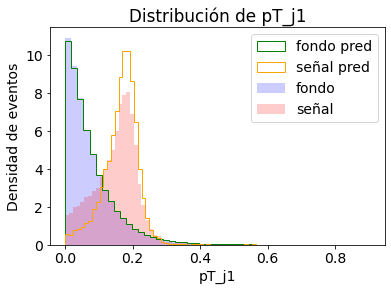

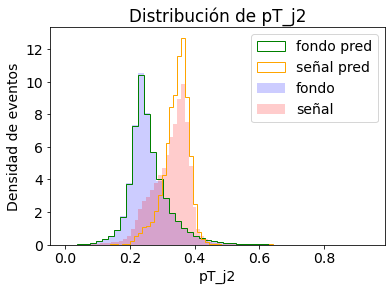

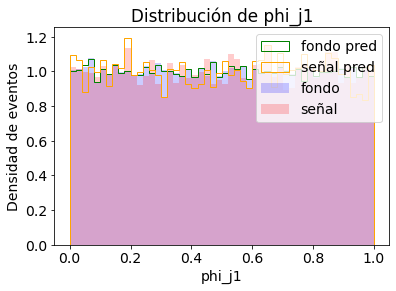

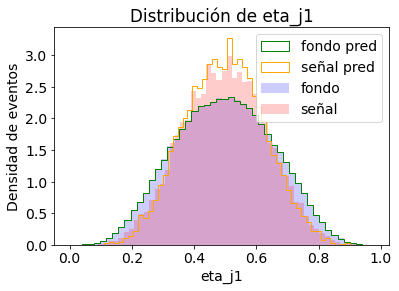

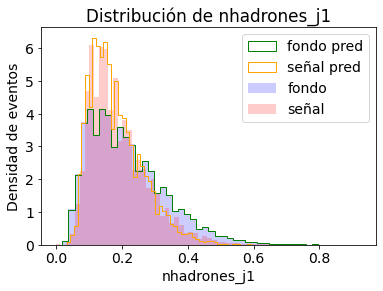

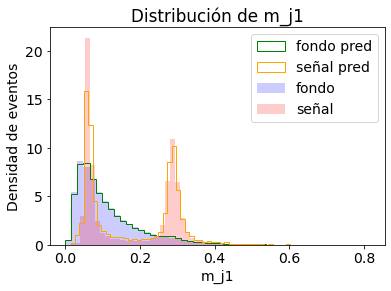

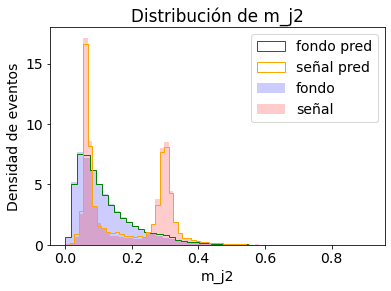

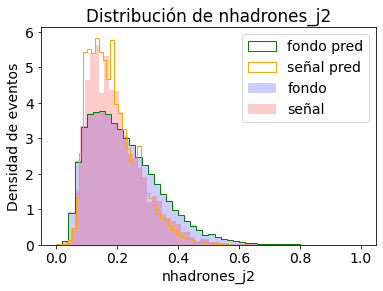

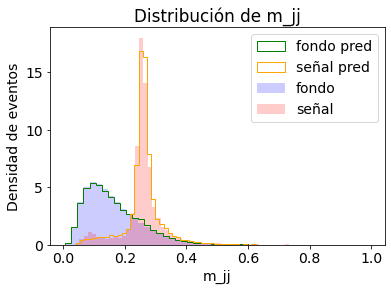

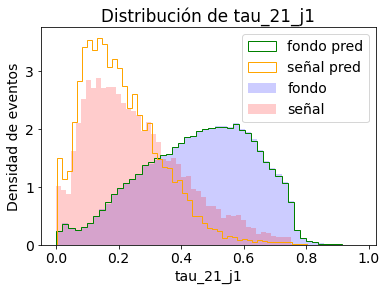

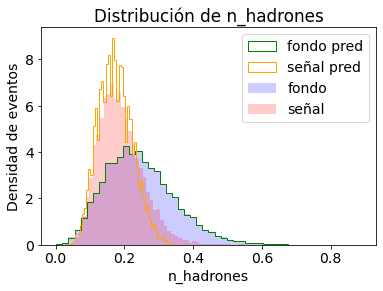

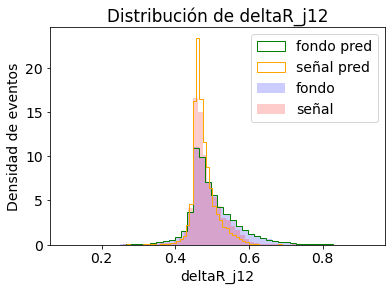

In [23]:
lista = ['pT_j1', 'pT_j2', 'phi_j1', 'eta_j1', 'nhadrones_j1',  
         'm_j1', 'm_j2', 'nhadrones_j2', 'm_jj','tau_21_j1', 
         'n_hadrones', 'deltaR_j12']

for variable in lista:
        plot_comp(X_test_m, variable)